In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs import *

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
cohort = 'eddy'
ss = 10

BatchSize = 128
learnRate = 1e-3
nm = 'student'
so = None
rr = 0
rv = 100 
r = 0

In [3]:
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

pretty_printing = analysisProteins

tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))

tr_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_so.zip'.format(cohort, ss))
te_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_so.zip'.format(cohort, ss))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


# Phenograph label

In [4]:
#pheno = pd.read_csv('/home/campbell/yulee/DAMM/new/res/basel/10k/pheno/model/phenograph_assignments_30_1.csv')

#import phenograph
#communities1, graph, Q = phenograph.cluster(np.hstack((trY, trS.reshape(-1,1))), k=30)

import scanpy.external as sce
trY, trS, _ = prepData(tr_exp, 2, analysisProteins)
communities, _, _ = sce.tl.phenograph(np.hstack((trY, trS.reshape(-1,1))), clustering_algo="louvain", k=30)
tr_exp.obs['pheno_cluster'] = communities.astype(str)

## set number of clusters
nc = len(np.unique(communities))

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 5.22397518157959 seconds
Jaccard graph constructed in 1.2882726192474365 seconds
Wrote graph to binary file in 0.290402889251709 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794167
After 3 runs, maximum modularity is Q = 0.798726
Louvain completed 23 runs in 7.925418376922607 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 15.00893497467041 seconds


In [5]:
phenograph_nc = len(np.unique(communities))
pheno_exps = np.zeros((phenograph_nc, trY.shape[1]))
pheno_size = np.zeros(phenograph_nc)
for k in range(phenograph_nc):
    #phen_means[i,:] = Y[phen_assign.iloc[:,1]==i].mean(0)
    pheno_exps[k,:] = trY[communities==k].mean(0)
    pheno_size[k] = np.array(trS[communities==k]).mean()

# Kmeans Initalization

In [6]:
trY, trS, Theta = prepData(tr_exp, nc, analysisProteins)
trFY, trFS, trFL = simulate_data(trY, trS)
torch.save(Theta, "/home/campbell/yulee/DAMM/new/res/{}/{}k/damm/theta0_nc{}_{}_rv{}_so{}_rr{}_test".format(cohort, ss, nc, nm, rv, so, rr))

teY, teS, _ = prepData(te_exp, nc, analysisProteins)
teFY, teFS, teFL = simulate_data(teY, teS)

In [7]:
## get labels & sorted mu & psi
km_pred_singlet_label, km_pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)
sorted_by_count = pd.Series(km_pred_singlet_cluster_assig_label[0]).value_counts().index
mu0 = Theta['log_mu'].exp().detach()
psi0 = Theta['log_psi'].exp().detach()
smu0 = mu0[sorted_by_count]
spsi0 = psi0[sorted_by_count]

## kmeans cluster
tr_exp.obs['kmeans_cluster'] = smu0.shape[0] + 1
tr_exp.obs.iloc[np.where(km_pred_singlet_label[0] == 0)[0],-1] = np.array(km_pred_singlet_cluster_assig_label[0])
tr_exp.obs['kmeans_cluster'] = tr_exp.obs['kmeans_cluster'].astype(str)

sc.pp.neighbors(tr_exp, use_rep='X')
sc.tl.umap(tr_exp)

# Random Forest

In [8]:
import joblib
## get random forest classifier
rf = RandomForestClassifier()
rf.fit(torch.hstack([trFY, trFS.reshape(-1,1)]), trFL)
rf_p_fake_singlet = rf.predict_proba(torch.hstack([teFY, teFS.reshape(-1,1)]))[:,1]
rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec = evalM(rf_p_fake_singlet, teFL)
#torch.hstack([teFY, teFS.reshape(-1,1)])
joblib.dump(rf, "/home/campbell/yulee/DAMM/new/res/{}/{}k/damm/rf_nc{}_{}_rv{}_so{}_rr{}_test.joblib".format(cohort, ss, nc, nm, rv, so, rr))

['/home/campbell/yulee/DAMM/new/res/eddy/10k/damm/rf_nc15_student_rv100_soNone_rr0_test.joblib']

# DAMM

In [9]:
## run DAMM
loss, Theta = trainWFD(ConcatDataset(trY, trS, trFY, trFS, trFL), Theta, BatchSize, nm, learnRate, rv, so, tr_so, rr)
torch.save([loss, Theta], "/home/campbell/yulee/DAMM/new/res/{}/{}k/damm/theta1_nc{}_{}_rv{}_so{}_rr{}_test".format(cohort, ss, nc, nm, rv, so, rr))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
with torch.no_grad():
    ## watch out for when input matrix are big!!
    _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(teFY, teFS, Theta, nm, so, te_so, rr)
    
    tn, fp, fn, tp, acc, f1, sens, spec = evalM(damm_p_fake_singlet, teFL)
    cor2 = np.corrcoef(damm_p_fake_singlet, rf_p_fake_singlet)

    iter_out = [nc, nm, rv, so, rr, r, len(np.where(damm_p_fake_singlet > 0.5)[0]), tn, fp, fn, tp, acc, f1, sens, spec, 
            len(np.where(rf_p_fake_singlet > 0.5)[0]), rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec, cor2[0,1]]

    output_pred_doublet = pd.Series(iter_out) #.to_csv(output_pred_doublet)

## sorted mu & psi & get labels
damm_pred_singlet_label, damm_pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)

## damm mu & psi
mu1 = Theta['log_mu'].exp().detach()
psi1 = Theta['log_psi'].exp().detach()

damm_sorted_by_count = pd.Series(damm_pred_singlet_cluster_assig_label[0]).value_counts().index
smu1 = mu1[damm_sorted_by_count]
spsi1 = psi1[damm_sorted_by_count]

## damm cluster
tr_exp.obs['damm_cluster'] = smu1.shape[0] + 1
tr_exp.obs.iloc[np.where(damm_pred_singlet_label[0] == 0)[0],-1] = np.array(damm_pred_singlet_cluster_assig_label[0])
tr_exp.obs['damm_cluster'] = tr_exp.obs['damm_cluster'].astype(str)

# Loss Curve

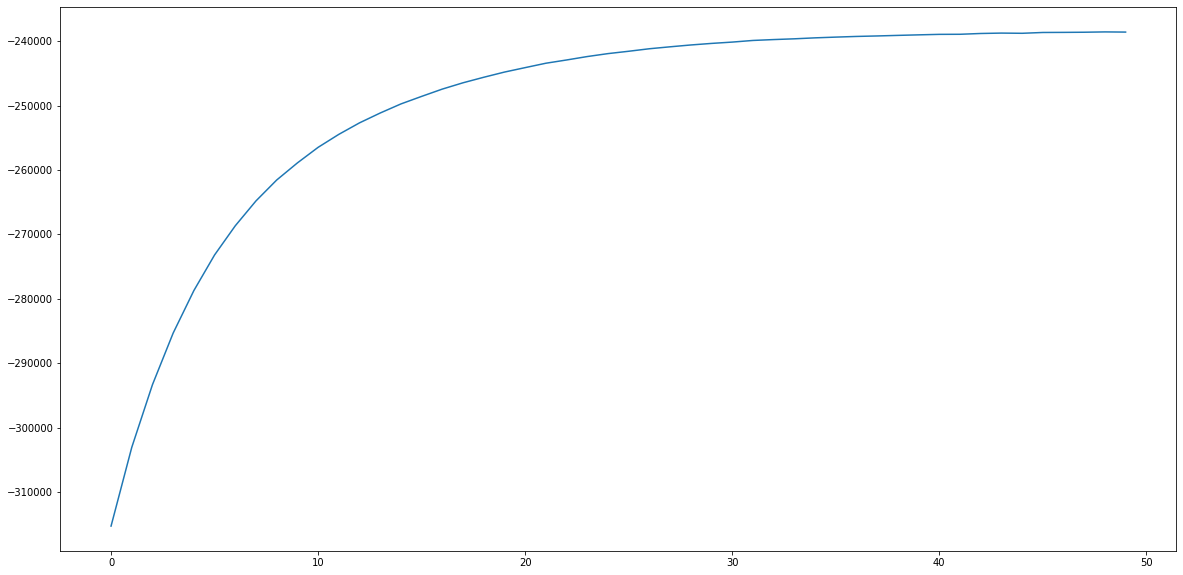

In [11]:
## total loss
plt.plot(np.array(loss)[:,0])

# Doublet Probability

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pheno_cluster' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans_cluster' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: 

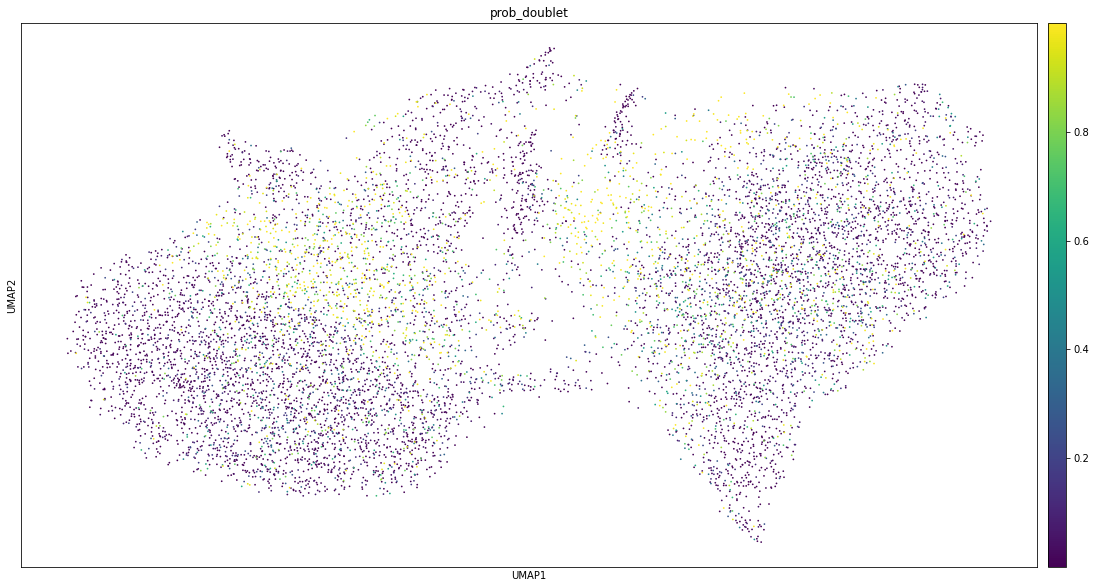

In [12]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta, nm, so, tr_so, rr)
    
tr_exp.obs['prob_doublet'] = 1 - np.array(p_singlet.detach())
sc.pl.umap(tr_exp, color="prob_doublet")

# Expression Heatmap (scaled)

In [13]:
scaler = MinMaxScaler()
#s2 = scaler.fit(phen_means)
s2 = scaler.fit(np.vstack([pheno_exps, smu0, smu1]))

Text(156.0, 0.5, 'Cluster')

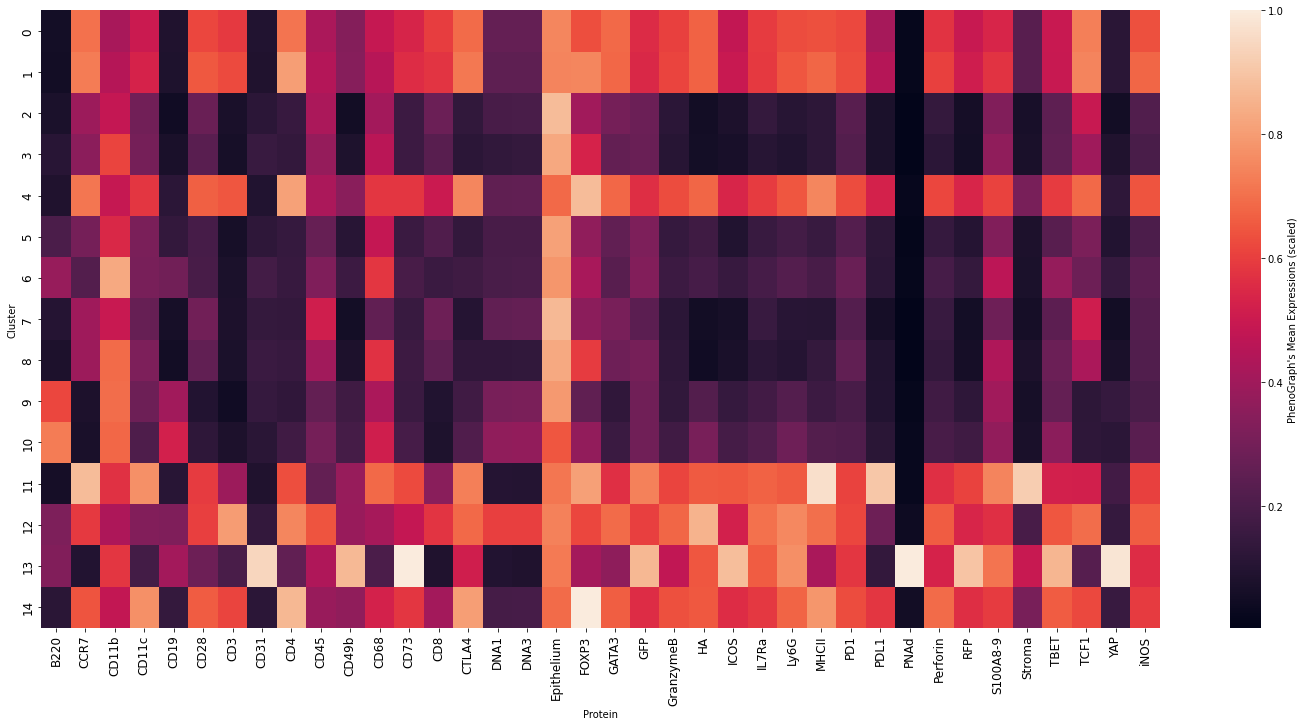

In [14]:
## phenograph
s3 = scaler.transform(pheno_exps)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "PhenoGraph's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

In [15]:
## doublet probability for each cluster
rf.predict_proba(np.hstack([pheno_exps, pheno_size.reshape(-1,1)]))[:,0]

array([0.21, 0.2 , 0.14, 0.24, 0.78, 0.27, 0.99, 0.32, 0.75, 0.31, 0.66,
       0.05, 0.17, 0.31, 0.99])

Text(156.0, 0.5, 'Cluster')

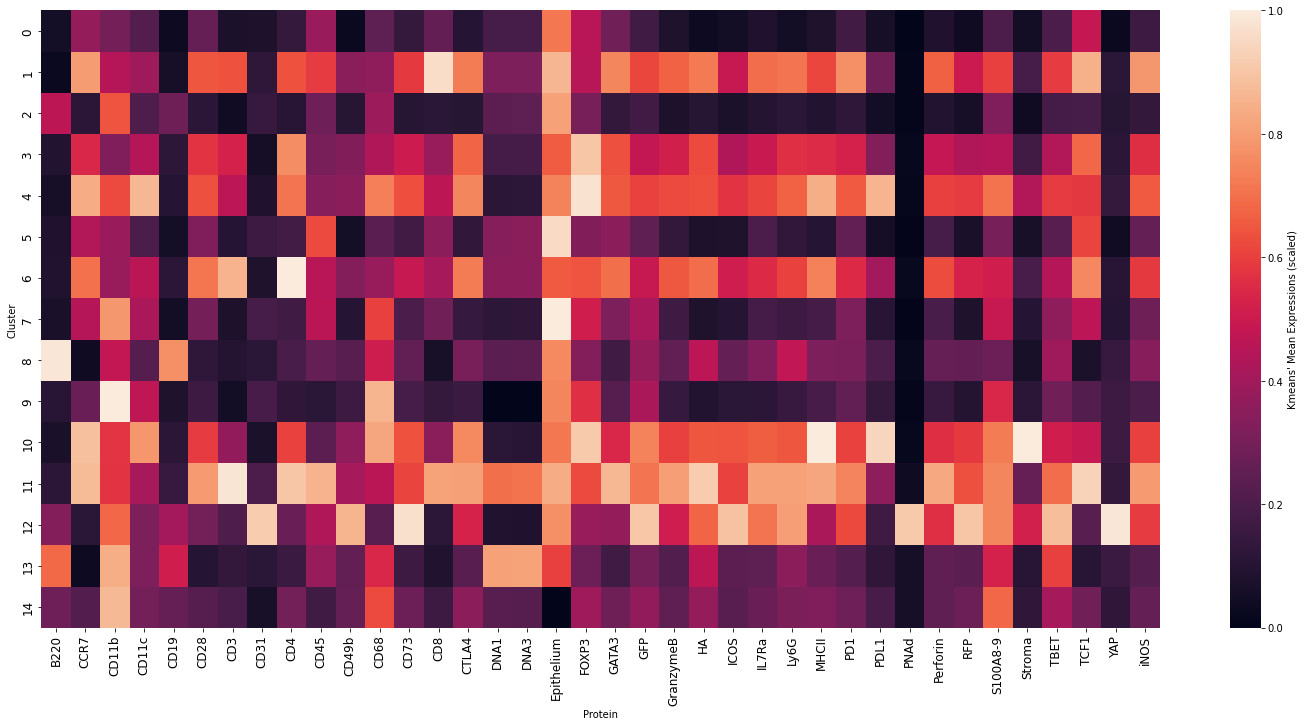

In [16]:
## kmeans
s3 = scaler.transform(smu0)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

In [17]:
## doublet probability for each cluster
rf.predict_proba(torch.hstack([smu0, spsi0.reshape(-1,1)]))[:,0]

array([0.21, 0.12, 0.32, 0.32, 0.13, 0.21, 0.17, 0.22, 0.4 , 0.29, 0.09,
       0.17, 0.27, 0.45, 0.75])

Text(156.0, 0.5, 'Cluster')

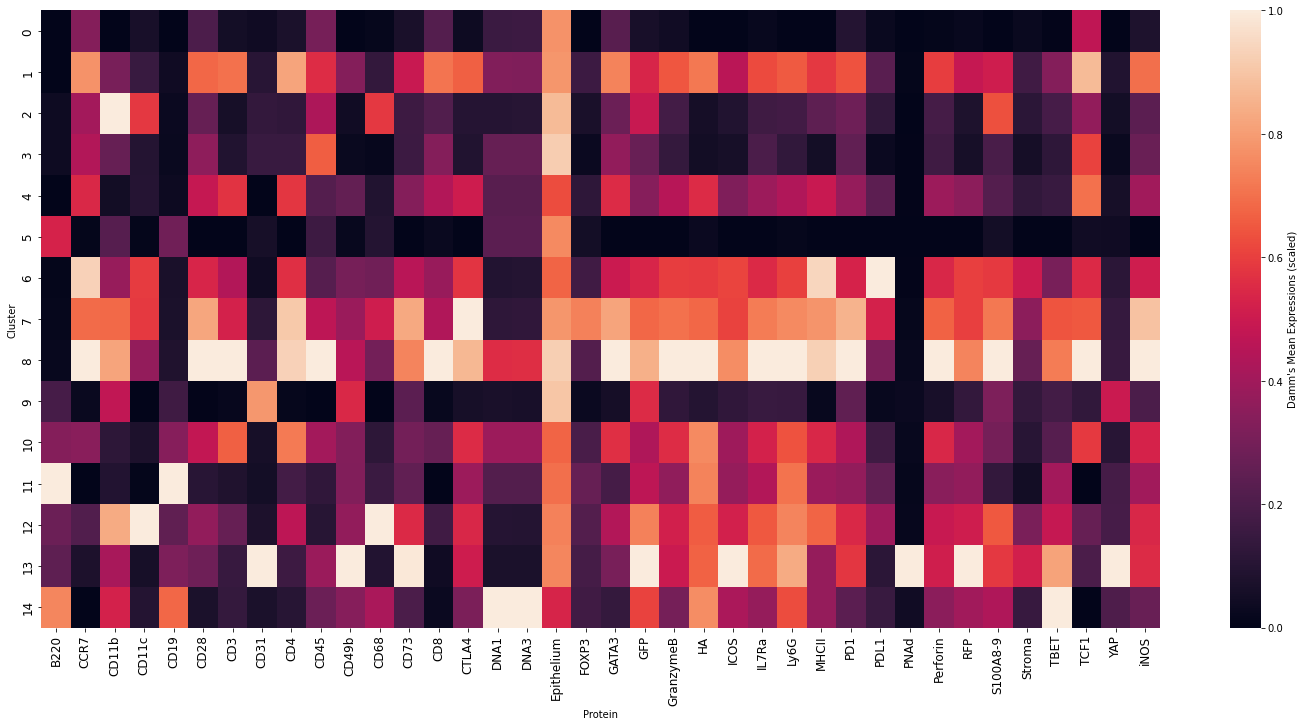

In [18]:
## damm
s3 = scaler.transform(smu1)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Damm's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

In [19]:
## doublet probability for each cluster
rf.predict_proba(torch.hstack([smu1, spsi1.reshape(-1,1)]))[:,0] 

array([0.12, 0.09, 0.13, 0.13, 0.09, 0.21, 0.15, 0.06, 0.11, 0.17, 0.12,
       0.02, 0.15, 0.08, 0.09])

# Expression Heatmap (arcsinh)

Text(156.0, 0.5, 'Cluster')

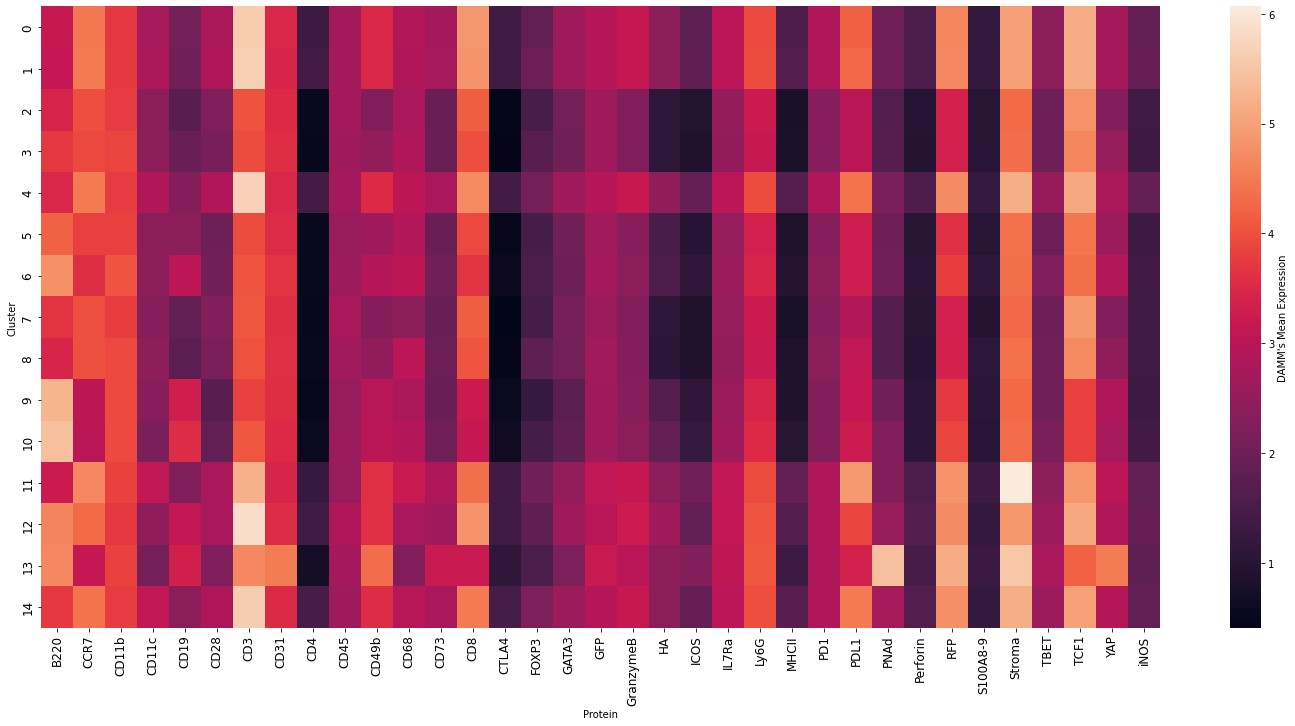

In [20]:
#mat = pd.DataFrame(np.arcsinh(np.array(pheno_exps)/0.1), columns = pretty_printing)
mat = pd.DataFrame(np.arcsinh(np.hstack([pheno_exps[:,:15], pheno_exps[:,18:]])/0.1), columns = np.hstack([pretty_printing[:15], pretty_printing[18:]]))
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

Text(156.0, 0.5, 'Cluster')

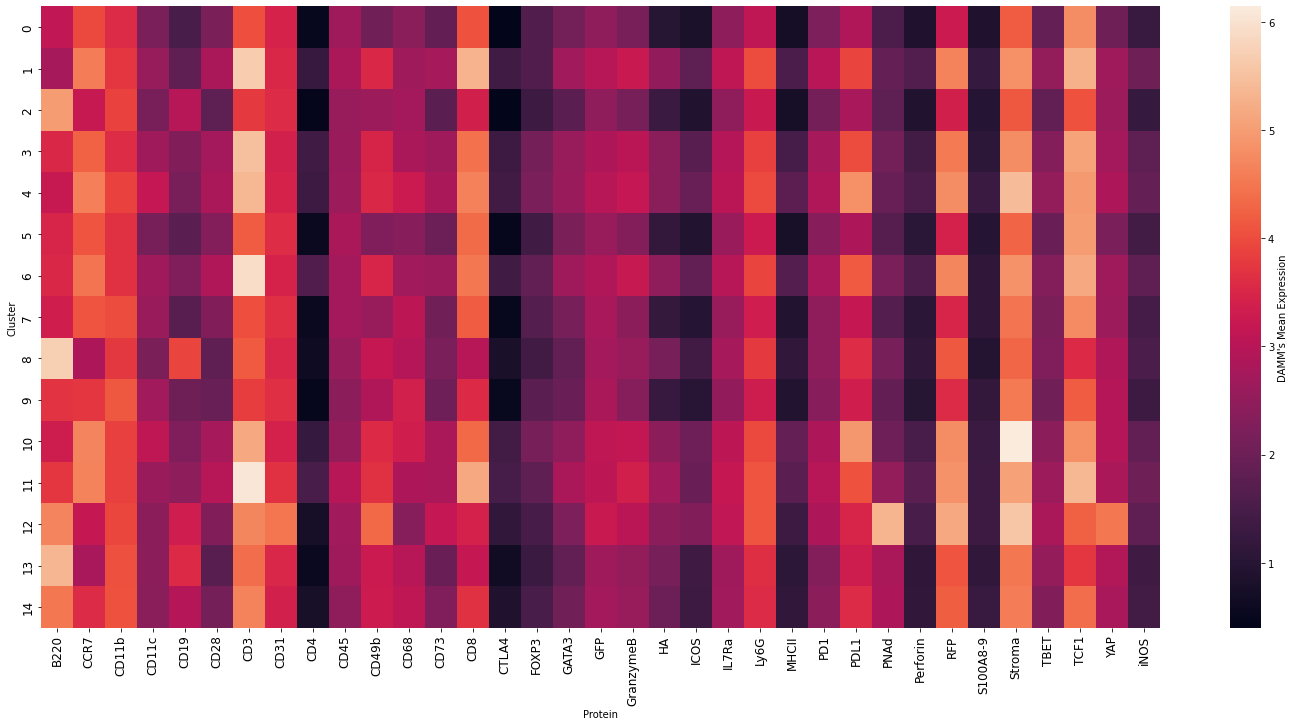

In [21]:
#mat = pd.DataFrame(np.arcsinh(np.array(smu0)/0.1), columns = pretty_printing)
mat = pd.DataFrame(np.arcsinh(np.hstack([smu0[:,:15], smu0[:,18:]])/0.1), columns = np.hstack([pretty_printing[:15], pretty_printing[18:]]))
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

Text(156.0, 0.5, 'Cluster')

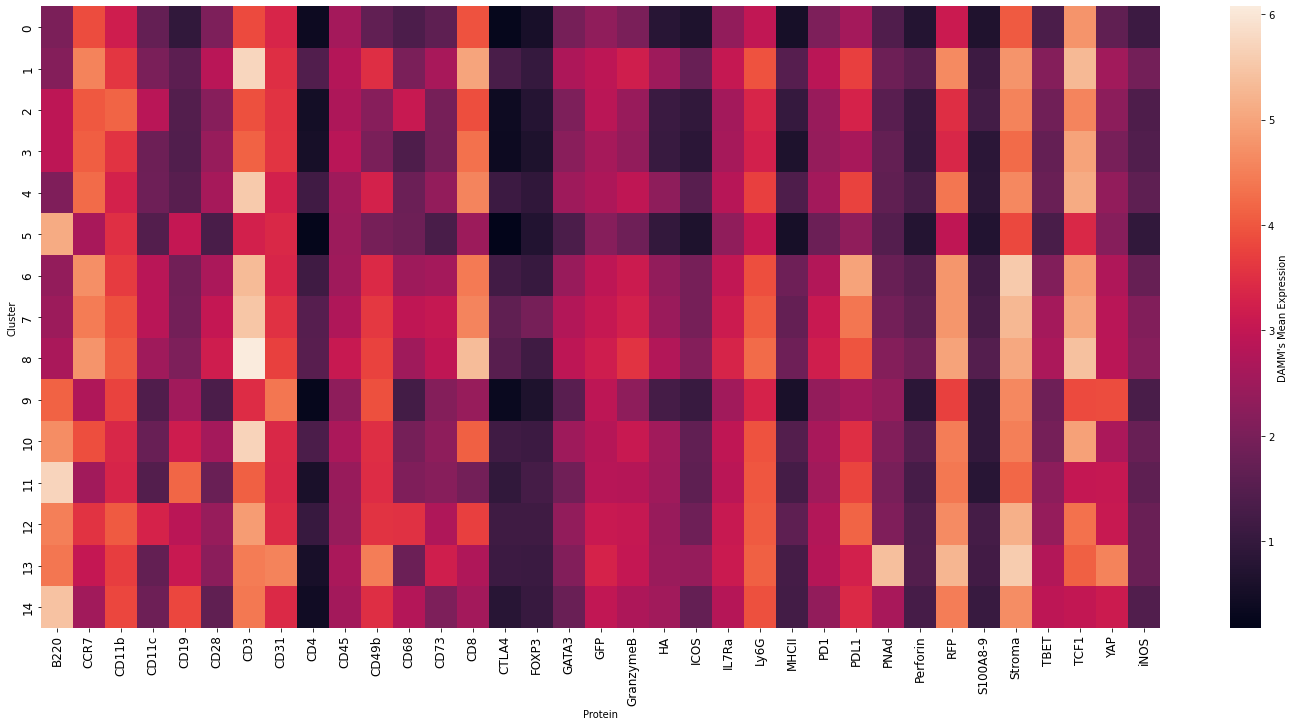

In [22]:
#mat = pd.DataFrame(np.arcsinh(np.array(smu1)/0.1), columns = pretty_printing)
mat = pd.DataFrame(np.arcsinh(np.hstack([smu1[:,:15], smu1[:,18:]])/0.1), columns = np.hstack([pretty_printing[:15], pretty_printing[18:]]))
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

# UMAP of PhenoGraph/Kmeans/DAMM clusters

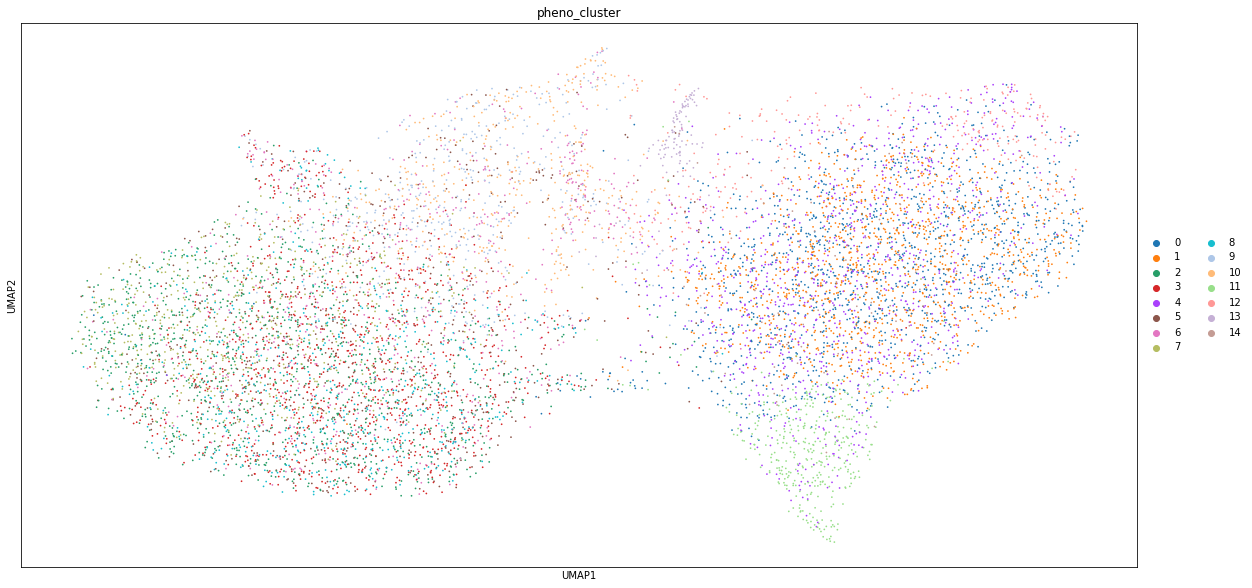

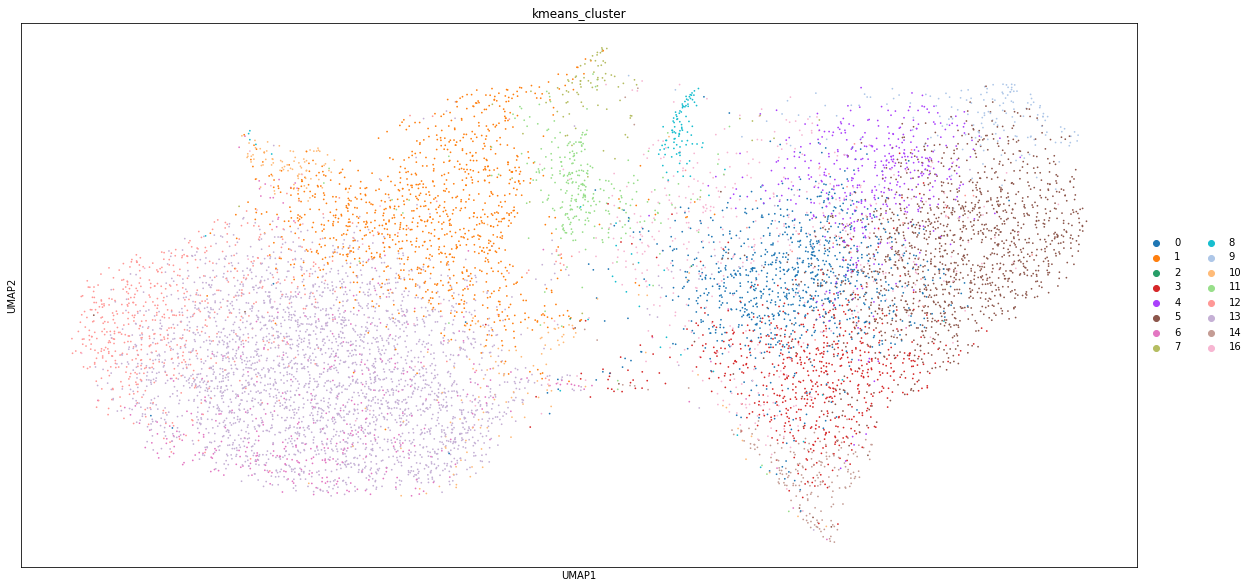

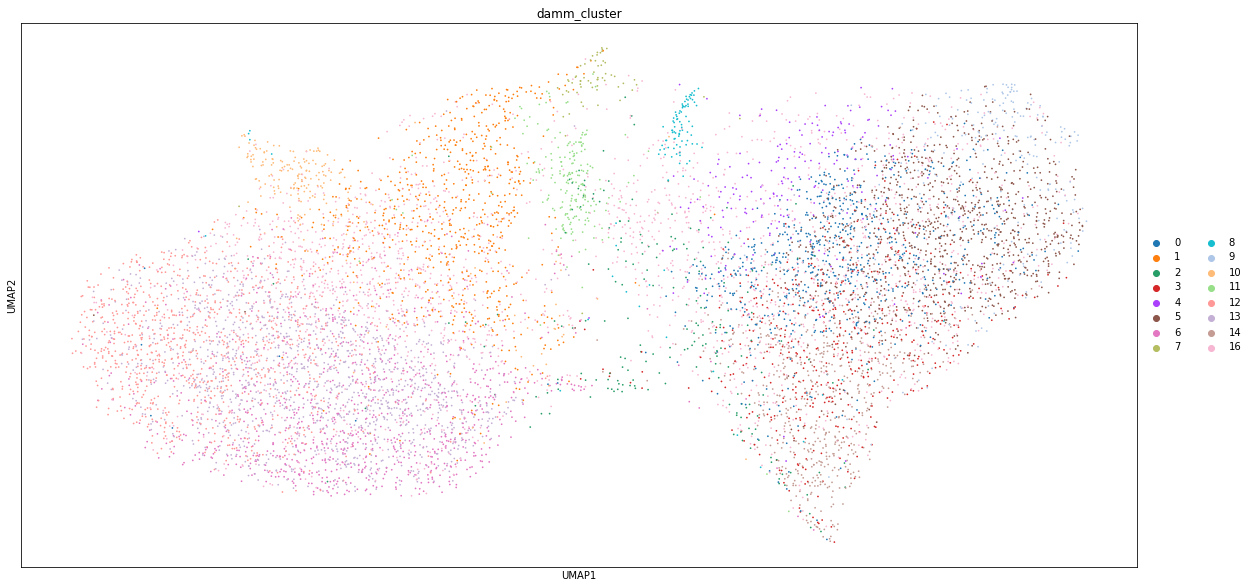

In [23]:
sc.pl.umap(tr_exp, color="pheno_cluster")
sc.pl.umap(tr_exp, color="kmeans_cluster")
sc.pl.umap(tr_exp, color="damm_cluster")

# Correlation PhenoGraph/Kmeans/DAMM

In [24]:
## PhenoGraph
df_corr = pd.DataFrame(np.array(pheno_exps), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.34698196199609577
correlation between CD45 vs CD8:           0.5693772896671742
correlation between CD45 vs CD11b:         -0.5846780084436158
correlation between CD45 vs CD19:          -0.1646205942580876
correlation between CD45 vs CD28:          0.43286364613343203
correlation between CD45 vs CD68:          -0.47775035936144655
correlation between CD4 vs CD8:            0.8556462319188509
correlation between CD4 vs CD28:           0.9677141235094086
correlation between CD8 vs CD28:           0.9040942231783522
correlation between Stroma vs CD31:        0.24928029897739706
correlation between Stroma vs Epithelium:  -0.4832269254968693
correlation between Epithelium vs CD4:     -0.5940261659983607
correlation between Epithelium vs CD8:     -0.18446076355726906
correlation between Epithelium vs CD11b:   0.06486664635491213
correlation between Epithelium vs CD31:    -0.10752692631302416
correlation between Epithelium vs CD19:    -0.5117801066

In [25]:
## kmeans
df_corr = pd.DataFrame(np.array(smu0), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.39033856072484485
correlation between CD45 vs CD8:           0.7035304896423707
correlation between CD45 vs CD11b:         -0.4006094625758498
correlation between CD45 vs CD19:          -0.24442391526392368
correlation between CD45 vs CD28:          0.5346137658249221
correlation between CD45 vs CD68:          -0.5378905893970767
correlation between CD4 vs CD8:            0.6973825716899081
correlation between CD4 vs CD28:           0.9453265207137197
correlation between CD8 vs CD28:           0.8320533675727262
correlation between Stroma vs CD31:        0.2412111577606928
correlation between Stroma vs Epithelium:  0.009029676269380161
correlation between Epithelium vs CD4:     -0.023946826922009397
correlation between Epithelium vs CD8:     0.29274018531490126
correlation between Epithelium vs CD11b:   -0.29115585512668374
correlation between Epithelium vs CD31:    0.18818733403748392
correlation between Epithelium vs CD19:    -0.2153098940

In [26]:
## damm
df_corr = pd.DataFrame(np.array(smu1), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.5299584296483082
correlation between CD45 vs CD8:           0.7947276504882168
correlation between CD45 vs CD11b:         0.2739206571004429
correlation between CD45 vs CD19:          -0.3657809499799681
correlation between CD45 vs CD28:          0.7349044288460215
correlation between CD45 vs CD68:          -0.0590792730655777
correlation between CD4 vs CD8:            0.8119675670055525
correlation between CD4 vs CD28:           0.936312316221319
correlation between CD8 vs CD28:           0.9112919990834663
correlation between Stroma vs CD31:        0.4045591441290524
correlation between Stroma vs Epithelium:  -0.09452190193269727
correlation between Epithelium vs CD4:     -0.001021865318501843
correlation between Epithelium vs CD8:     0.3382786857266857
correlation between Epithelium vs CD11b:   0.3659382011670323
correlation between Epithelium vs CD31:    0.32908713532658357
correlation between Epithelium vs CD19:    -0.5081839689873789


# Cell sizes by cluster

<AxesSubplot:xlabel='cluster', ylabel='size'>

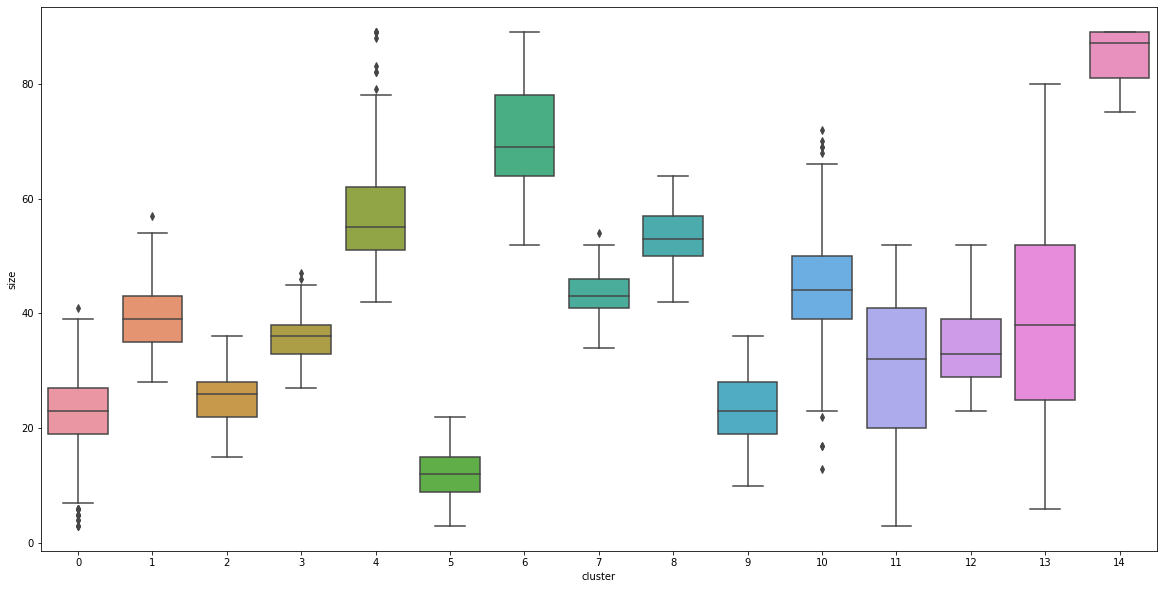

In [27]:
## phenograph
d1 = pd.DataFrame({'cluster': range(pheno_exps.shape[0]), 'psi': pheno_size})
d2 = pd.DataFrame({'size': trS, 'cluster': communities})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

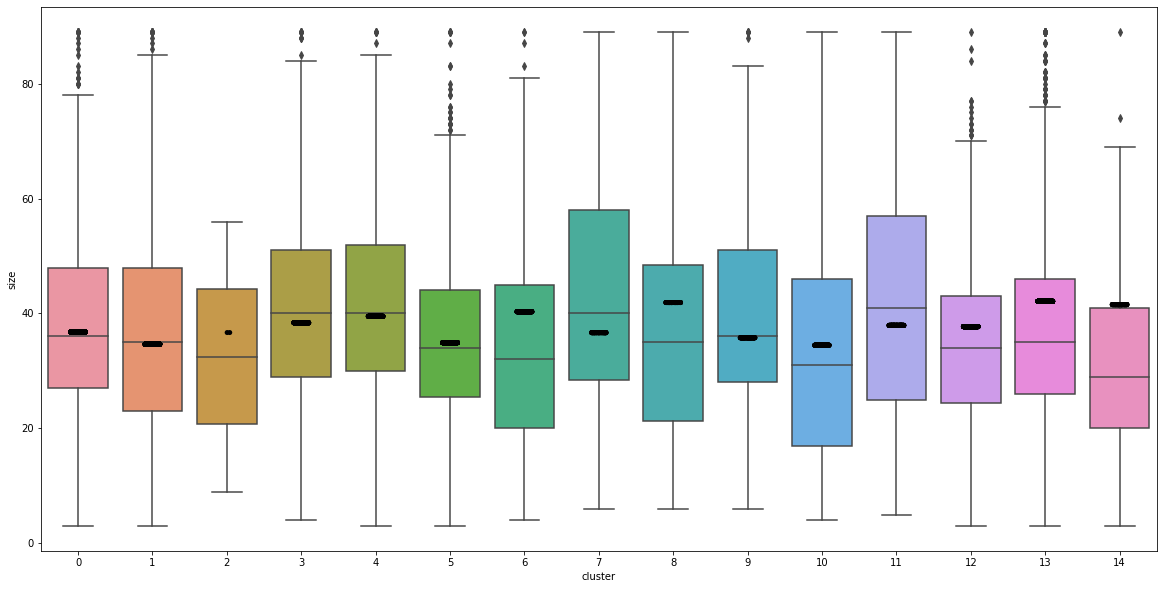

In [28]:
## kmeans
d1 = pd.DataFrame({'cluster': range(smu0.shape[0]), 'psi': spsi0})
d2 = pd.DataFrame({'size': trS[km_pred_singlet_label[0] == 0], 
                   'cluster': np.array(km_pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

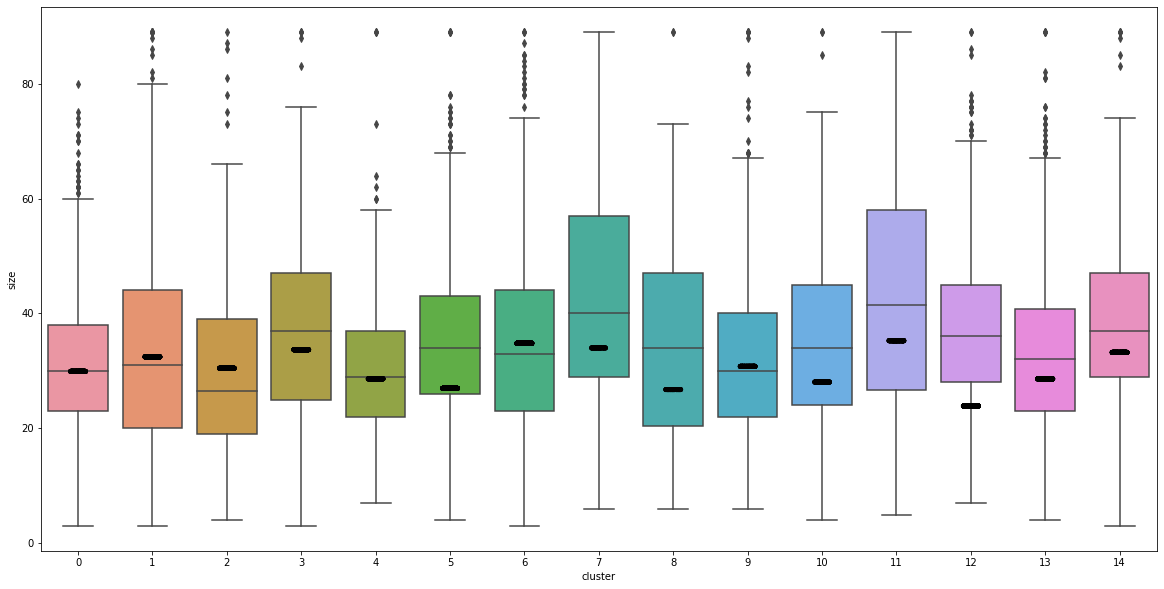

In [29]:
## damm
d1 = pd.DataFrame({'cluster': range(smu1.shape[0]), 'psi': spsi1})
d2 = pd.DataFrame({'size': trS[damm_pred_singlet_label[0] == 0], 
                   'cluster': np.array(damm_pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

# ARS of PhenoGraph/Kmeans/DAMM

In [30]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(tr_exp.obs['damm_cluster'], tr_exp.obs['kmeans_cluster'])

0.27531917623419444

In [31]:
adjusted_rand_score(tr_exp.obs['damm_cluster'], tr_exp.obs['pheno_cluster'])

0.11985787883794602

In [32]:
adjusted_rand_score(tr_exp.obs['kmeans_cluster'], tr_exp.obs['pheno_cluster'])

0.1753844992953625